# Exercise - approximating a stress-strain relation with a neural network

In this exercise, you will build a neural network to reconstruct the model parameters from given stress-strain curves. Let us assume that the stress-strain relation is well approximated [_Ramberg-Osgood_](https://en.wikipedia.org/wiki/Ramberg–Osgood_relationship) model, which represents a non-linear relation between the stress $\sigma$  and the strain $\epsilon$, namely
$$ \sigma = C \epsilon^{1/n}.$$
Here, $C$ and $n$ denote the material parameters, which should be identified based on given stress-strain curves. Specifically, for each stress-strain curve, the model should output a pair $(C,n)$: hence, we are dealing with a _multi-target regression_ problem.

In [1]:
import matplotlib.pyplot as plt
from data.data_generator import StressStrainDataGenerator
from torch import nn
import torch
from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
# Auxiliary functions
def get_stress_from_model(eps, C, n):
    return C*eps**(1.0/n)

In [3]:
# generate dataset: each sample (row) consists of strains and stresses arranged sequentially 
# (first NUM_DATAPOINTS columns corresponds to strains, the rest to the associated stresses)
NUM_DATAPOINTS = 101
stressStrainDataGenerator = StressStrainDataGenerator(num_datapoints=NUM_DATAPOINTS) 
stressStrainDataGenerator.std_noise =  0.554
X, y = stressStrainDataGenerator.generate_stress_strain_datasets(num_samples=2000,
                                                                          C_range=[5,15],
                                                                          n_range=[2,5],
                                                                          shuffle=True,
                                                                          add_noise=True,
                                                                          eps_linear_distributed=False)

1. Plot 6 stress-strain curves of the dataset using a scatter plot. Display a legend that relates the values of $C$ and $n$ to each curve.

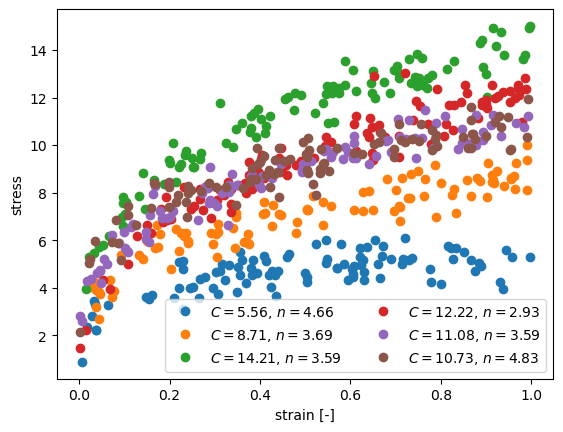

In [4]:
num_plotted_curves = 6
for sample_index in range(0, num_plotted_curves):
    strains = X[sample_index][0:NUM_DATAPOINTS]
    stresses = X[sample_index][NUM_DATAPOINTS:]
    label = '$C = {:.2f}$, $n = {:.2f}$'.format(*y[sample_index])
    plt.plot(strains, stresses, 'o', label=label)
plt.xlabel("strain [-]")
plt.ylabel("stress")
plt.legend(ncol=2);

2. Split the dataset into training and test sets (0.8-0.2) using the _scikit-learn_ function [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Call the resulting arrays `X_train`, `X_test`, `y_train`, `y_test`.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

3. Create a _PyTorch_ neural network class that implements a multi-layer perceptron to predict the values of $C$ and $n$ given an array combining strains and stresses. Fix the number of hidden layers to 3 and define a parameter called `hidden_units` in the constructor of the class that allows to change the number of units for each hidden layer (for simplicity, assume that the number is the same for all hidden layers).

**NOTE**: in the `forward` method of the class, process the input _x_ with the instruction `x = x.to(torch.float32)` before passing it to the hidden layers.

In [18]:
# these tensors must be used for the training of the neural network
X_ = torch.tensor(X_train, dtype=torch.float32)
y_ = torch.tensor(y_train, dtype=torch.float32)

In [19]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_units=50):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2*NUM_DATAPOINTS, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 2)
        )

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.linear_relu_stack(x)
        return x

4. Create a _skorch_ `NeuralNetRegressor` object (see the docs [here](https://skorch.readthedocs.io/en/stable/regressor.html)) that wraps the Pytorch model. Set the learning rate equal to 0.01 and the batch size equal to 64. Disable train/validation split, set the parameter `verbose=0` (to avoid printing anything during the grid search runs, see point 6) and set the number of epochs equal to 20. Check that the optimizer is set to SGD and that the loss function is MSE. When calling the _NeuralNetRegressor_ constructor, also pass the parameter `module__hidden_units=10` to set the default number of hidden units.   

In [20]:
model = NeuralNetRegressor(module=NeuralNetwork, lr=0.01, batch_size=64, verbose=0,
                           max_epochs=20, train_split=None, module__hidden_units=10)

5. Create a `scikit-learn` _Pipeline_ object that appropriately standardizes the dataset and feeds it to the _NeuralNetRegressor_ object. Name the model object in the pipeline as `model`. 

In [21]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', model),
])

6. Use the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) interface of _scikit-learn_ to carry out a grid search on the parameter called `model__module__hidden_units` (which is passed to the `model` in the pipeline that you just built). Use 3-fold cross-validation. Also check the _User Guide_ of _scikit-learn_ about the grid search. Print the number of hidden units that results in the best validation score.

In [22]:
params = {
    'model__module__hidden_units': [10*(i+1) for i in range(10)],
}
gs = GridSearchCV(pipe, params, cv=3, verbose=3)
gs.fit(X_, y_)

print(gs.best_score_, gs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ....model__module__hidden_units=10;, score=0.930 total time=   0.2s
[CV 2/3] END ....model__module__hidden_units=10;, score=0.857 total time=   0.1s
[CV 3/3] END ....model__module__hidden_units=10;, score=0.853 total time=   0.1s
[CV 1/3] END ....model__module__hidden_units=20;, score=0.884 total time=   0.1s
[CV 2/3] END ....model__module__hidden_units=20;, score=0.866 total time=   0.1s
[CV 3/3] END ....model__module__hidden_units=20;, score=0.889 total time=   0.1s
[CV 1/3] END ....model__module__hidden_units=30;, score=0.935 total time=   0.1s
[CV 2/3] END ....model__module__hidden_units=30;, score=0.926 total time=   0.1s
[CV 3/3] END ....model__module__hidden_units=30;, score=0.902 total time=   0.1s
[CV 1/3] END ....model__module__hidden_units=40;, score=0.942 total time=   0.1s
[CV 2/3] END ....model__module__hidden_units=40;, score=0.945 total time=   0.1s
[CV 3/3] END ....model__module__hidden_units=40;

7. Plot the training loss vs number of epochs for the best model found in the grid search.

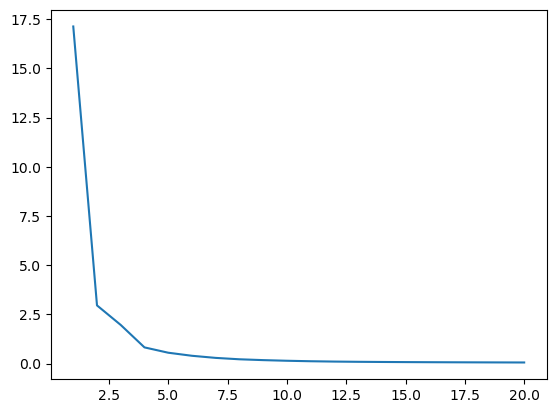

In [23]:
train_loss = gs.best_estimator_['model'].history[:, 'train_loss']
plt.plot([i for i in range(1,21)], train_loss)
plt.show()

8. Using the best model obtained from the grid search, generate the predictions over the test set and evaluate the $R^2$ on this set. Plot the stresses and the strains corresponding to one sample of the test set along with the curve obtained using the function `get_stress_from_model` with the values of $C$ and $n$ estimated by the trained neural network.

In [24]:
p = gs.predict(X_test)
gs.score(X_test, y_test)

0.9543441390477716

[7.520217  3.6222053]
[7.9407234  3.71063454]


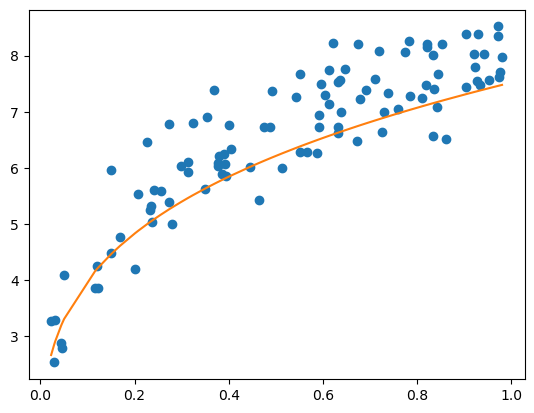

In [25]:
sample_number = 1
strains_stresses = X_test[sample_number]
C, n = p[sample_number]
print(p[sample_number])
print(y_test[sample_number])
strains = X_test[sample_number][:NUM_DATAPOINTS]
stresses = X_test[sample_number][NUM_DATAPOINTS:]
pred_stresses = get_stress_from_model(strains, C, n)
plt.plot(strains, stresses, 'o')
plt.plot(strains, pred_stresses)
plt.show()